In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
%matplotlib inline

# Functions

In [2]:
def merg_and_drop(data,store,feature):
    df_merge = data.merge(feature, how='left',on=["Store","Date","IsHoliday"]).merge(store, how='left', on=["Store"] )

    # sum of NaN
    nan_sum = df_merge.isnull().sum().sum()
    
    # Replace the NaN values in markdown with 0
    df_merge_tidy = df_merge.fillna(0)
    #df_merge_tidy = df_merge.dropna()

    return df_merge_tidy

In [3]:
def score(model, X_test, y_test, y_pred, CV):
    
    #The mean absolute error
    print('\nMAE: %f' % mean_absolute_error(y_test, y_pred))

    # The mean squared error
    print('\nMSE: %f' % mean_squared_error(y_test, y_pred))

    # The coefficient of determination: 1 is perfect prediction
    print('\nR2 score: %.3f\n' % r2_score(y_test, y_pred))
    
    if (CV == True):
    #K fold cross validation
        print('cross_val_score_R2: %.3f\n '%cross_val_score(model, train_X, train_y,  cv = 5, n_jobs=-1).mean())
        
    # Weighted mean absolute error
    weights = X_test.IsHoliday.apply(lambda x: 5 if x else 1)
    wmae = np.sum(weights*abs(y_test - y_pred))/(np.sum(weights))
    print('\nWMAE: %f\n' % wmae)

In [4]:
def plot_pred(y_test, y_pred):
    fig, ax = plt.subplots()
    ax.scatter(y_test, y_pred)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.title('Prediction Errors Visualization',fontsize= 14)
    plt.show()
    
    return (y_test, y_pred)

#  Load Data

In [5]:
train = pd.read_csv('./data/train.csv')
feature = pd.read_csv('./data/features.csv')
store = pd.read_csv('./data/stores.csv')
test = pd.read_csv('./data/test.csv')

In [6]:
train['Year'] = pd.DatetimeIndex(train['Date']).year
train['Month'] = pd.DatetimeIndex(train['Date']).month
train['Week'] = pd.DatetimeIndex(train['Date']).week

# Merge and Clean Data

In [7]:
# Perform merge and (dropna or fillna(0))
train_merge = merg_and_drop(train,store,feature)
print('Size of Data',train_merge.shape)
print('NaN value =',train_merge.isnull().values.any())

Size of Data (421570, 19)
NaN value = False


In [8]:
# Creating dummy variables for "Type"
train_merge_tidy =pd.get_dummies(train_merge, columns=["Type"])

###  Features in Training data has large difference in range and there are lots of outliers 

In [9]:
# Get the general idea of the dataframe
train_merge_tidy.describe().round(1)

,Store,Dept,Weekly_Sales,Year,Month,Week,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Type_A,Type_B,Type_C
count,421570.0,421570.0,421570.0,421570.0,421570.0,421570.0,421570.0,421570.0,421570.0,421570.0,421570.0,421570.0,421570.0,421570.0,421570.0,421570.0,421570.0,421570.0,421570.0
mean,22.2,44.3,15981.3,2011.0,6.4,25.8,60.1,3.4,2590.1,880.0,468.1,1083.1,1662.8,171.2,8.0,136727.9,0.5,0.4,0.1
std,12.8,30.5,22711.2,0.8,3.2,14.2,18.4,0.5,6052.4,5084.5,5528.9,3894.5,4207.6,39.2,1.9,60980.6,0.5,0.5,0.3
min,1.0,1.0,-4988.9,2010.0,1.0,1.0,-2.1,2.5,0.0,-265.8,-29.1,0.0,0.0,126.1,3.9,34875.0,0.0,0.0,0.0
25%,11.0,18.0,2079.6,2010.0,4.0,14.0,46.7,2.9,0.0,0.0,0.0,0.0,0.0,132.0,6.9,93638.0,0.0,0.0,0.0
50%,22.0,37.0,7612.0,2011.0,6.0,26.0,62.1,3.5,0.0,0.0,0.0,0.0,0.0,182.3,7.9,140167.0,1.0,0.0,0.0
75%,33.0,74.0,20205.9,2012.0,9.0,38.0,74.3,3.7,2809.0,2.2,4.5,425.3,2168.0,212.4,8.6,202505.0,1.0,1.0,0.0
max,45.0,99.0,693099.4,2012.0,12.0,52.0,100.1,4.5,88646.8,104519.5,141630.6,67474.8,108519.3,227.2,14.3,219622.0,1.0,1.0,1.0


## ----------------------------- Done with data cleaning and processing ------------------------------------------

# Data Exploration

You are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and you are tasked with predicting the **department-wide sales** for each store.

In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the **Super Bowl, Labor Day, Thanksgiving, and Christmas**. *The weeks including these holidays are weighted **five times** higher in the evaluation than non-holiday weeks*. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.

### Average Sales per Year

In [10]:
train_sales_average = train.groupby(['Year','Week'])['Weekly_Sales'].agg(np.mean).reset_index()

year_2010 = train_sales_average['Year'] == 2010
year_2011 = train_sales_average['Year'] == 2011
year_2012 = train_sales_average['Year'] == 2012
#train_sales_average.head()

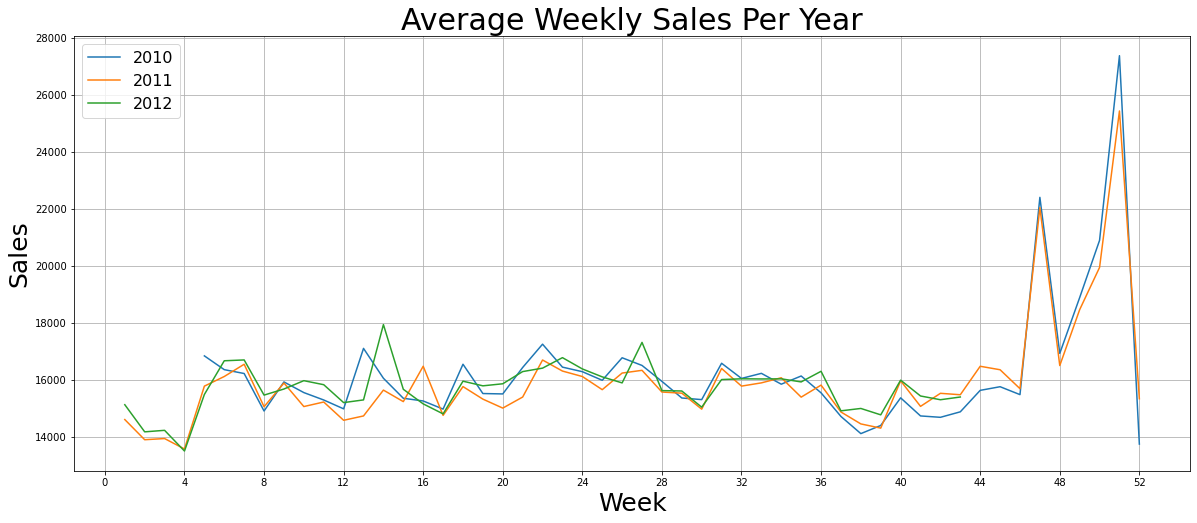

In [11]:
plt.figure(figsize=(20,8))
plt.plot(train_sales_average[year_2010]['Week'], train_sales_average[year_2010]['Weekly_Sales'])
plt.plot(train_sales_average[year_2011]['Week'], train_sales_average[year_2011]['Weekly_Sales'])
plt.plot(train_sales_average[year_2012]['Week'], train_sales_average[year_2012]['Weekly_Sales'])
plt.grid()
plt.xticks(np.arange(0, 53, step=4))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Average Weekly Sales Per Year', fontsize=30)
plt.ylabel('Sales', fontsize=25)
plt.xlabel('Week', fontsize=25)
plt.show()

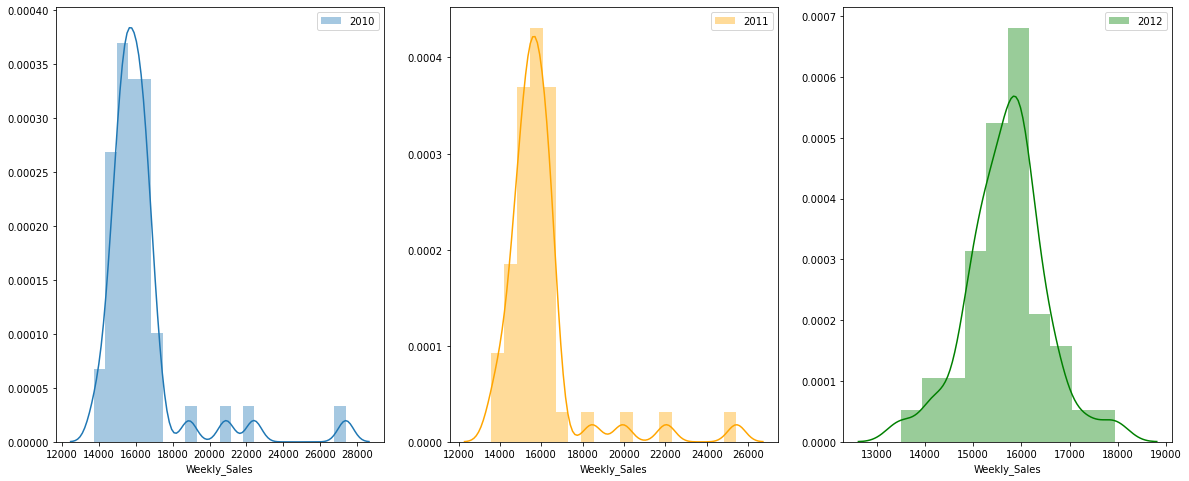

In [12]:
plt.figure(figsize=(20,8))
ax1=plt.subplot(1, 3, 1)
sns.distplot(train_sales_average[year_2010]['Weekly_Sales'],label='2010')
plt.legend()

ax2=plt.subplot(1, 3, 2)
sns.distplot(train_sales_average[year_2011]['Weekly_Sales'],label='2011',color="orange")
plt.legend()

ax3=plt.subplot(1, 3, 3)
sns.distplot(train_sales_average[year_2012]['Weekly_Sales'],label='2012',color='g')
plt.legend()
plt.show()

### Average Sales per store

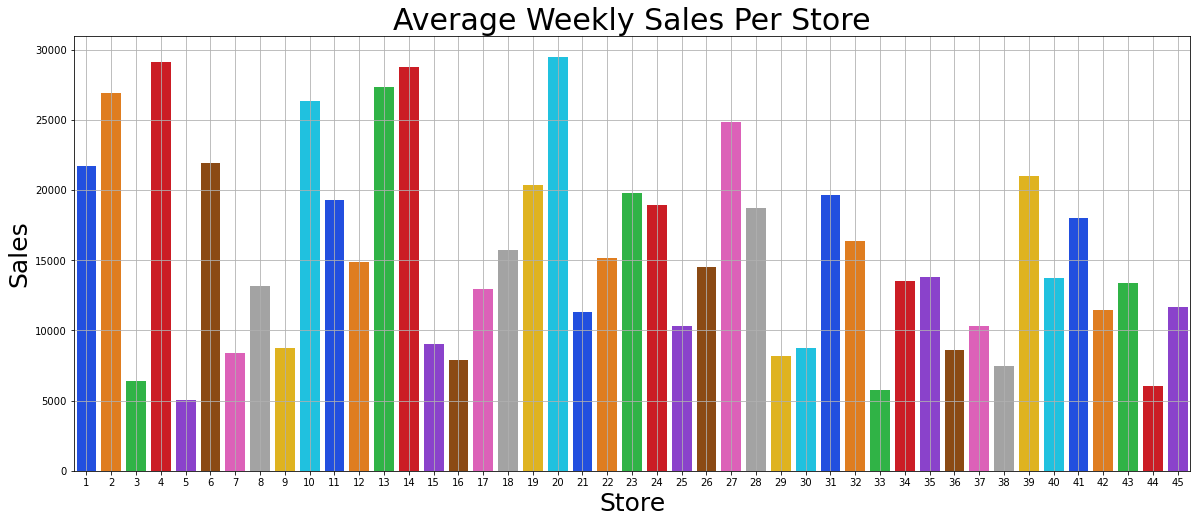

In [13]:
train_sales_store = train.groupby(['Store'])['Weekly_Sales'].agg(np.mean).reset_index()
#train_sales_store.head()
plt.figure(figsize=(20,8))
sns.barplot(train_sales_store['Store'], train_sales_store['Weekly_Sales'],  palette="bright")
plt.grid()
plt.title('Average Weekly Sales Per Store', fontsize=30)
plt.ylabel('Sales', fontsize=25)
plt.xlabel('Store', fontsize=25)
plt.show()

### Average Sales per Deptartment



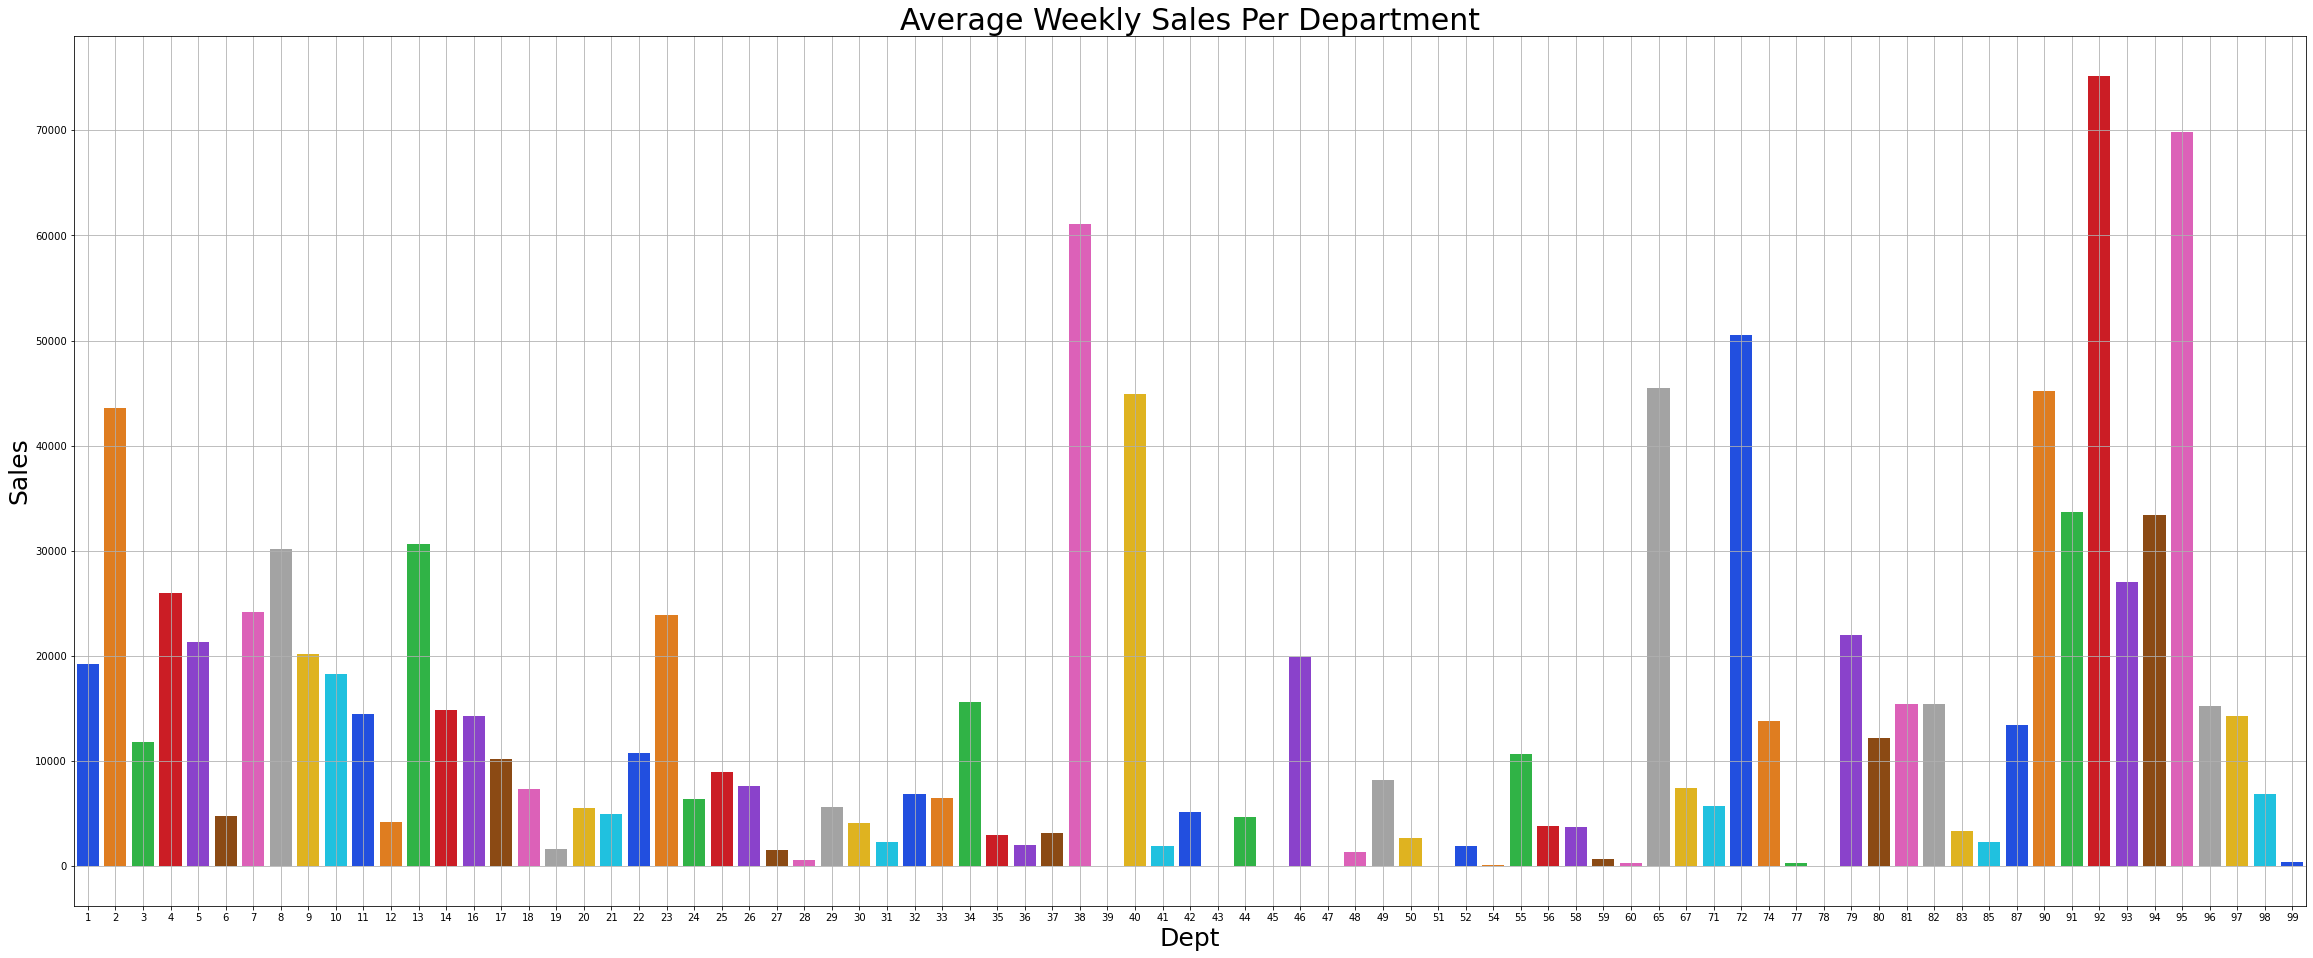

In [14]:
train_sales_dept = train.groupby(['Dept'])['Weekly_Sales'].agg(np.mean).reset_index()
#train_sales_dept.head()
plt.figure(figsize=(20*2,8*2))
sns.barplot(train_sales_dept['Dept'], train_sales_dept['Weekly_Sales'], palette='bright')
plt.grid()
plt.title('Average Weekly Sales Per Department', fontsize=30)
plt.ylabel('Sales', fontsize=25)
plt.xlabel('Dept', fontsize=25)
plt.show()

#### Some Weekly_sales in Holidays is extremly larger than not in Holidays

#### There are about 5 departments have larger weekly sales than rest of others

#### Weekly_sales is highest in 2010 and lowest in 2012

#### Holidays are located on week 2, 9, 11, 12 
#### (Super Bowl, Labor Day, Thanksgiving, and Christmas)
#### these holidays are weighted five times higher in the evaluation than non-holiday weeks

Some data in 2012 is missing (there are only 2 holiday data out of 4)

Weekly sales in holiday is higher than in non-holiday

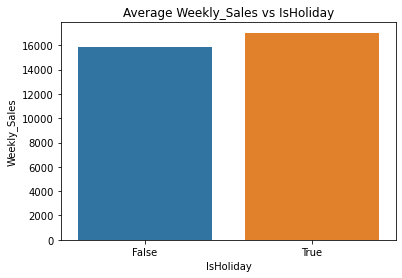

In [15]:
data = train_merge.groupby('IsHoliday')['Weekly_Sales'].mean().reset_index()
ax = sns.barplot(x = data.IsHoliday, y = data.Weekly_Sales, )
plt.title('Average Weekly_Sales vs IsHoliday');

Type is relative to size
Large- size Store have more Weekly Sales

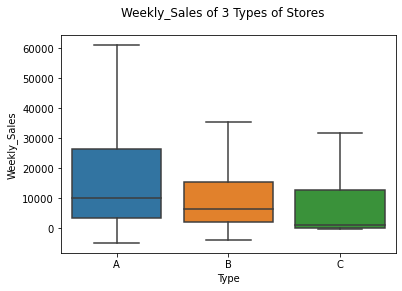

In [16]:
sns.boxplot(x='Type', y='Weekly_Sales', data=train_merge,
           showfliers=False)
           #hue='IsHoliday')#,col='IsHoliday')
plt.suptitle('Weekly_Sales of 3 Types of Stores')
plt.show()

#### Type of store is a feature

####  One way to try and understand the data is by looking for correlations between the features and the target. 

0.00-.19 "very weak"

0.20-0.39 “weak”


0.40-0.59 “moderate”


0.60-0.79 “strong”


0.80-1.0 “very strong

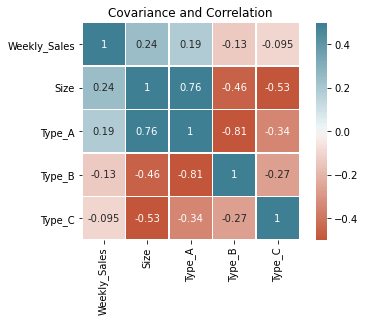

In [17]:
corr_Store = train_merge_tidy[['Weekly_Sales','Size','Type_A','Type_B','Type_C',]].corr()
# Heatmap

sns.heatmap(corr_Store, vmin= -0.5, vmax= 0.5, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True, linewidths=.5, annot=True,)
plt.title('Covariance and Correlation')
#plt.xticks(rotation=90, fontsize= 16)
plt.yticks(rotation=0, )
plt.show()

### Covariance

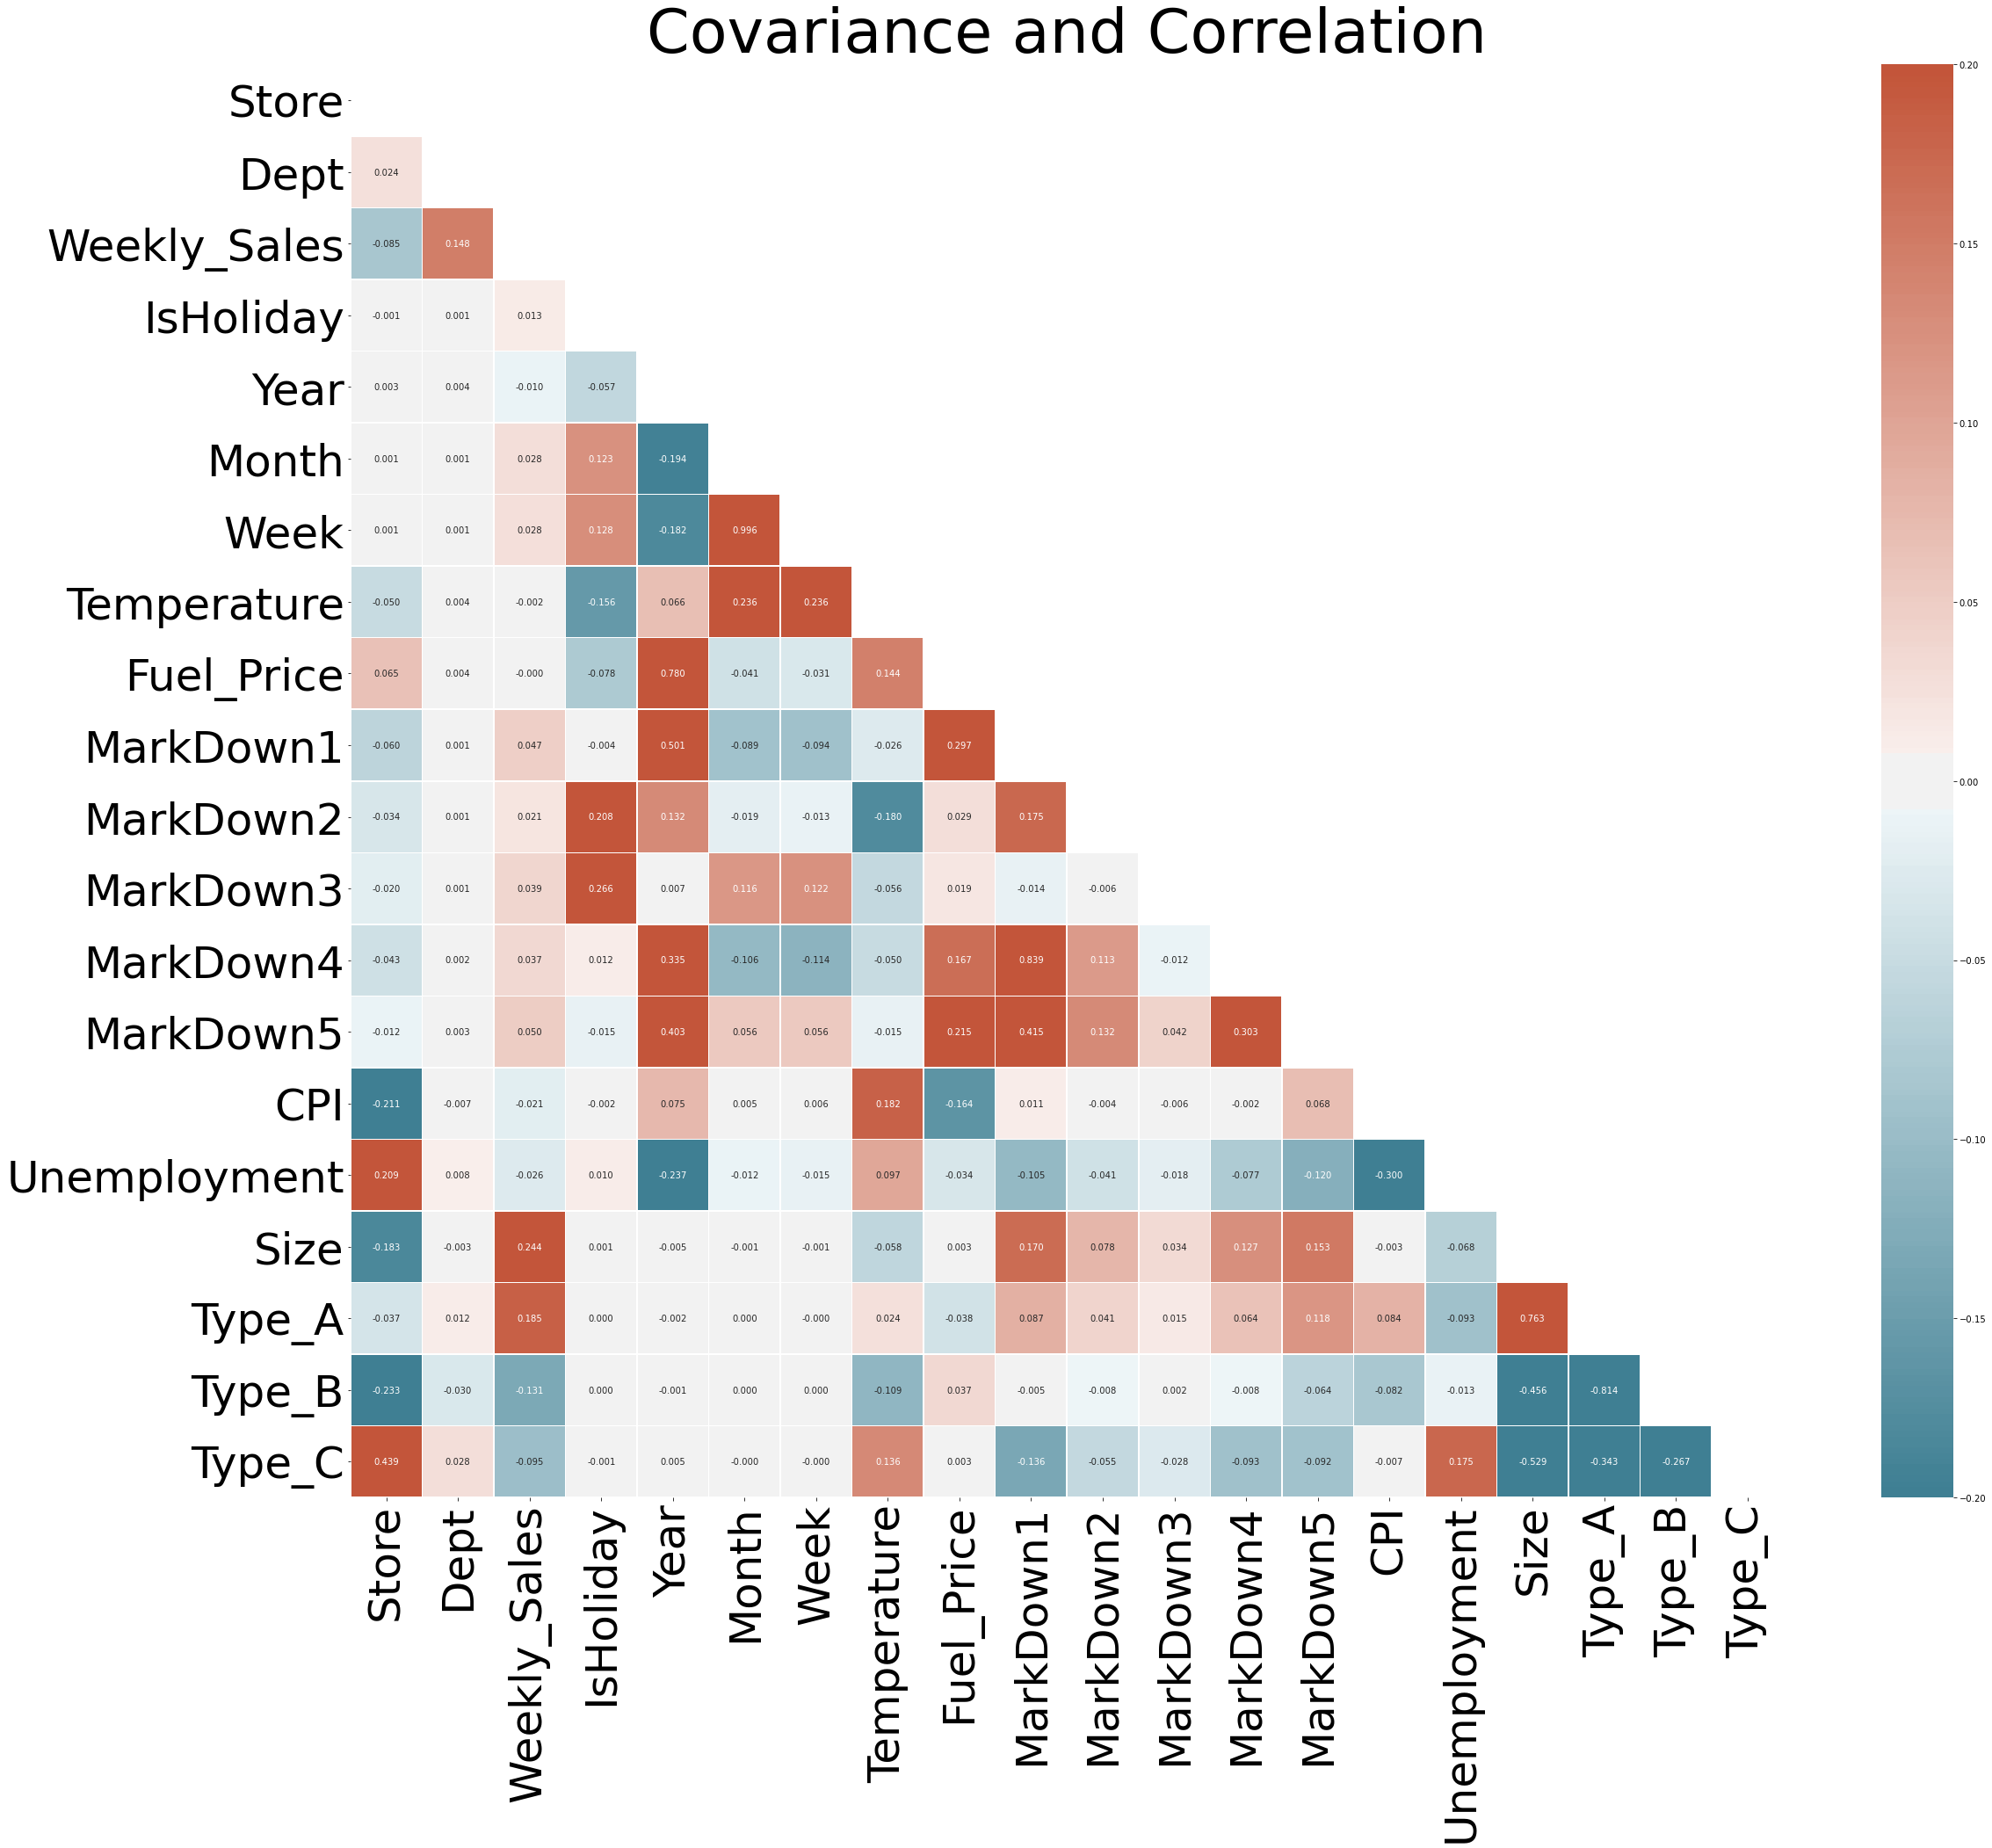

In [18]:
corr_train_merge_tidy = train_merge_tidy.corr()
# Heatmap
f, ax = plt.subplots(figsize=(20*2, 15*2))
mask = np.triu(np.ones_like(corr_train_merge_tidy, dtype=np.bool))
sns.heatmap(corr_train_merge_tidy,cmap=sns.diverging_palette(220, 20, n=200),
            mask=mask, vmin= -0.2, vmax= 0.2, center=0,
            #cmap=sns.diverging_palette(20, 220, n=200),
            square=True,fmt='.3f', linewidths=.6, annot=True,)
plt.title('Covariance and Correlation',fontsize= 70)
plt.xticks(rotation=90, fontsize= 50)
plt.yticks(rotation=0, fontsize= 50)
plt.show()

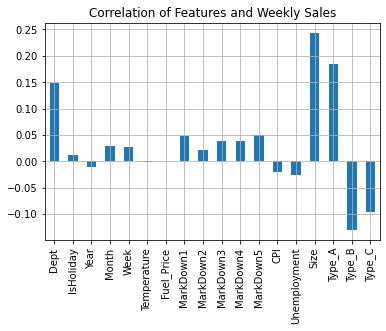

Dept            0.1480
IsHoliday       0.0128
Year           -0.0101
Month           0.0284
Week            0.0277
Temperature    -0.0023
Fuel_Price     -0.0001
MarkDown1       0.0472
MarkDown2       0.0207
MarkDown3       0.0386
MarkDown4       0.0375
MarkDown5       0.0505
CPI            -0.0209
Unemployment   -0.0259
Size            0.2438
Type_A          0.1854
Name: Weekly_Sales, dtype: float64

In [19]:
# Correlation between Weekly Sales and all other features
C = np.round(corr_train_merge_tidy['Weekly_Sales'][:].drop(["Store","Weekly_Sales"]),4)
C.plot.bar()
plt.grid()
plt.title('Correlation of Features and Weekly Sales')
plt.show()
C.head(16)

Temperature and fuel_Price have nearly zero corrlation to weekly Sales

Therefore following feature will be drop:
1.Store: Although it has a large corrlation, store is just an ID. It is a mixture of different features which affect the weekly sales in different ways such as location, size, type, stocks,etc

2.Date: will be drop because it can be represent as a combination of year month and week.

3.year,and month: Same as store, year is a mesurement of time which can be a mixture of feature. For instance, in 2008, during financial crisis, weekly sales will definently lower  

4 Temperature & Fuel_Price as we show there is nearly zero corrlation between weekly sales


## Feature selection


In [20]:
train_feature = train_merge_tidy.drop(columns=['Weekly_Sales','Date','Temperature', 'Fuel_Price'])
train_feature.head()

,Store,Dept,IsHoliday,Year,Month,Week,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Type_A,Type_B,Type_C
0,1,1,False,2010,2,5,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315,1,0,0
1,1,1,True,2010,2,6,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,151315,1,0,0
2,1,1,False,2010,2,7,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,151315,1,0,0
3,1,1,False,2010,2,8,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,151315,1,0,0
4,1,1,False,2010,3,9,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,151315,1,0,0


## Standardization

In [21]:
scaler = StandardScaler()
train_std = scaler.fit_transform(train_feature) 

# Sanity Check
#print(train_std.mean(axis = 0))
#print(train_std.std(axis = 0))

## Splite Training and Test data

In [22]:
#train_X = train_merge_tidy.drop(columns = ['Weekly_Sales','Date'])

# standard data
train_X = train_feature #train_std

train_y = train_merge_tidy["Weekly_Sales"]

X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2, shuffle=False, stratify=None)

### Linear Regression

In [23]:
%%time
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

Wall time: 409 ms


In [24]:
# Evaluation
score_reg = score(reg, X_test, y_test, y_pred, 1)
#cross_vale_score Return the coefficient of determination R^2 of the prediction.


MAE: 11899.959666

MSE: 342793574.805846

R2 score: 0.054

cross_val_score_R2: 0.069
 

WMAE: 12058.051272



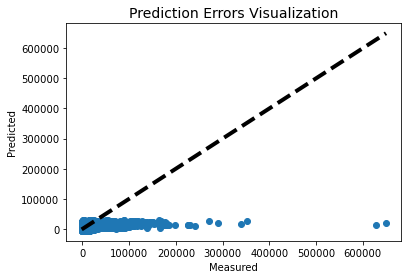

In [25]:
y_lr_test, y_lr_pred = plot_pred(y_test, y_pred)

## Decision Tree 

In [26]:
%%time
dt = DecisionTreeRegressor(random_state=0,criterion='mse')
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

Wall time: 2.71 s


In [27]:
# Evaluation
score_dt = score(dt, X_test, y_test, y_pred, 1)
#cross_vale_score Return the coefficient of determination R^2 of the prediction.


MAE: 4942.644573

MSE: 99790006.245289

R2 score: 0.724

cross_val_score_R2: 0.570
 

WMAE: 5054.164640



In [28]:
df1 =pd.DataFrame({'Feature_names': train_feature.columns,'Importances' : dt.feature_importances_})
df1_sort =df1.sort_values(by=['Importances'],ascending=False)
df1_sort

,Feature_names,Importances
1,Dept,0.625750
13,Size,0.205349
0,Store,0.058995
5,Week,0.043646
11,CPI,0.029536
4,Month,0.011277
12,Unemployment,0.010849
8,MarkDown3,0.002667
15,Type_B,0.002526
2,IsHoliday,0.001718


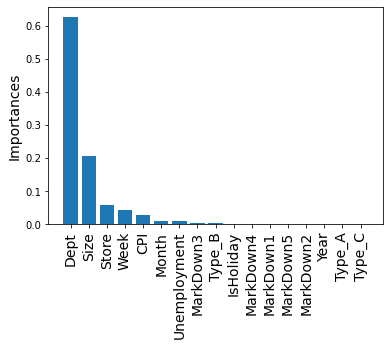

In [29]:
plt.bar(df1_sort['Feature_names'],df1_sort['Importances'])
plt.xticks(rotation=90, fontsize= 14)
plt.ylabel('Importances',fontsize= 14)
plt.show()

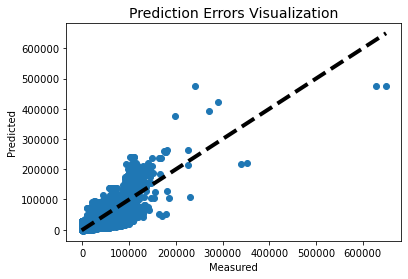

In [30]:
y_dt_test, y_dt_pred = plot_pred(y_test, y_pred)

## Random Forest Regression

In [31]:
%%time
rf = RandomForestRegressor(n_estimators=100, n_jobs = -1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

Wall time: 23 s


In [32]:
df2 = pd.DataFrame({'Feature_names': train_feature.columns,'Importances' : rf.feature_importances_})
df2_sort = df2.sort_values(by=['Importances'],ascending=False)
df2_sort

,Feature_names,Importances
1,Dept,0.627225
13,Size,0.203842
0,Store,0.055624
5,Week,0.044274
11,CPI,0.029992
12,Unemployment,0.012257
4,Month,0.007071
8,MarkDown3,0.006851
15,Type_B,0.002213
9,MarkDown4,0.002056


In [33]:
score_rf = score(rf, X_test, y_test, y_pred, 0)


MAE: 4355.599881

MSE: 81903125.305510

R2 score: 0.774


WMAE: 4447.600448



In [34]:
#score_rf = score(rf, X_test, y_test, y_pred, 1)
#cross_vale_score Return the coefficient of determination R^2 of the prediction.


MAE: 4355.599881

MSE: 81903125.305510

R2 score: 0.774

cross_val_score_R2: 0.657
 

WMAE: 4447.600448



In [35]:
#rf_cv =1
'''
cross_val_score_: 0.659
 
'''

'\ncross_val_score_: 0.659\n \n'

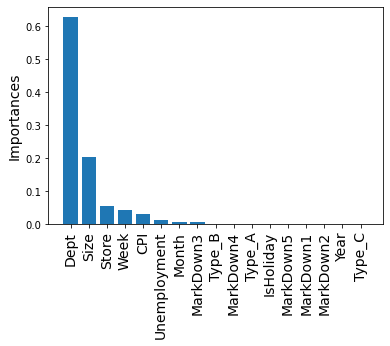

In [36]:
plt.bar(df2_sort['Feature_names'],df2_sort['Importances'])
plt.xticks(rotation=90, fontsize= 14)
plt.ylabel('Importances',fontsize= 14)
plt.show()

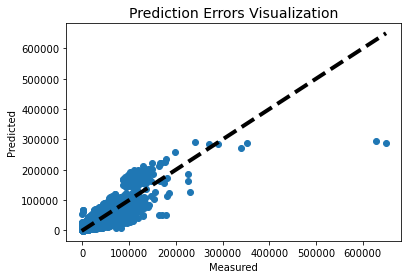

In [37]:
y_rf_test, y_rf_pred = plot_pred(y_test, y_pred)

### ExtraTreesRegressor

In [38]:
%%time
extra_tree = ExtraTreesRegressor(n_estimators=100, n_jobs= -1, criterion="mse")
extra_tree.fit(X_train, y_train)
y_pred = extra_tree.predict(X_test)

Wall time: 12.9 s


In [39]:
score_etr = score(extra_tree, X_test, y_test, y_pred, 0)


MAE: 3918.487482

MSE: 59419251.311403

R2 score: 0.836


WMAE: 3992.044880



In [40]:
#score_etr = score(extra_tree, X_test, y_test, y_pred, 1)
#cross_vale_score Return the coefficient of determination R^2 of the prediction.


MAE: 3918.487482

MSE: 59419251.311403

R2 score: 0.836

cross_val_score_R2: 0.806
 

WMAE: 3992.044880



In [41]:
#extra_tree CV=1
'''
cross_val_score_: 0.807
 

WMAE: 3879.268275
'''

'\ncross_val_score_: 0.807\n \n\nWMAE: 3879.268275\n'

In [42]:
df3 =pd.DataFrame({'Feature_names': train_feature.columns,'Importances' : extra_tree.feature_importances_})
df3_sort =df3.sort_values(by=['Importances'],ascending=False)
df3_sort

,Feature_names,Importances
1,Dept,0.744896
13,Size,0.078143
0,Store,0.039161
14,Type_A,0.032505
5,Week,0.028820
11,CPI,0.023434
4,Month,0.019135
12,Unemployment,0.009181
8,MarkDown3,0.006505
2,IsHoliday,0.006402


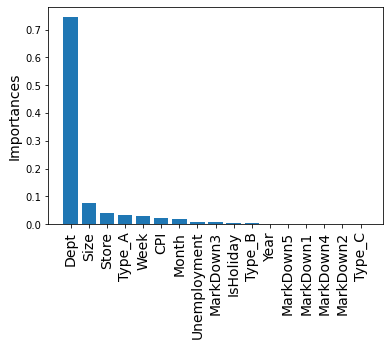

In [43]:
plt.bar(df3_sort['Feature_names'],df3_sort['Importances'])
plt.xticks(rotation=90, fontsize= 14)
plt.ylabel('Importances',fontsize= 14)
plt.show()

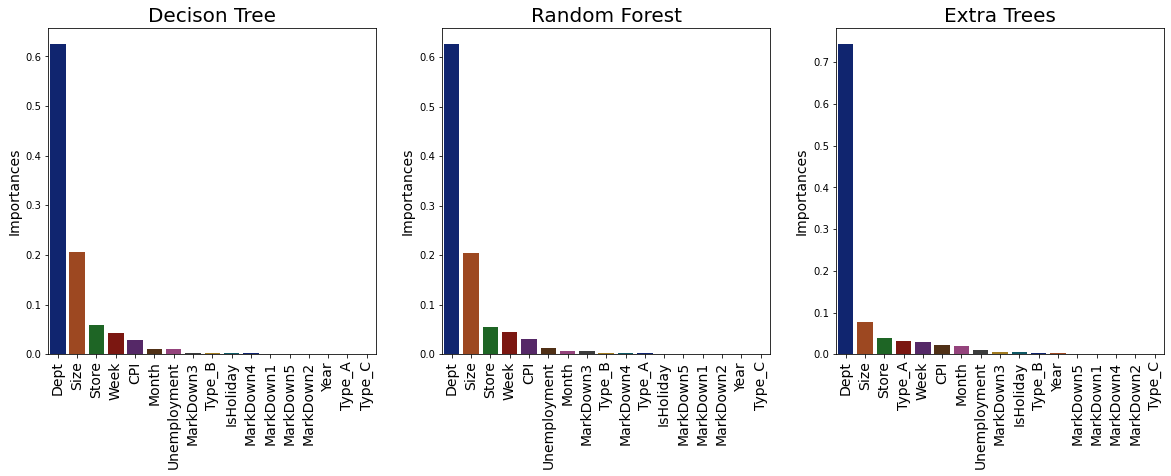

In [44]:
#Importance vs Feature
fig = plt.figure(figsize=(20,6))

ax1=plt.subplot(1, 3, 1)
sns.barplot(x =df1_sort['Feature_names'], y=df1_sort['Importances'],palette="dark")
plt.title ('Decison Tree',fontsize= 20)
plt.xticks(rotation=90, fontsize= 14)
plt.xlabel('')
plt.ylabel('Importances',fontsize= 14)

ax2=plt.subplot(1, 3, 2,)
sns.barplot(x =df2_sort['Feature_names'], y=df2_sort['Importances'],palette="dark")
plt.xticks(rotation=90, fontsize= 14)
plt.xlabel('')
plt.ylabel('Importances',fontsize= 14)
plt.title ('Random Forest',fontsize= 20)

ax3=plt.subplot(1, 3, 3,)
sns.barplot(x =df3_sort['Feature_names'], y=df3_sort['Importances'],palette="dark")
plt.xticks(rotation=90, fontsize= 14)
plt.xlabel('')
plt.ylabel('Importances',fontsize= 14)
plt.title ('Extra Trees',fontsize= 20)
plt.show()


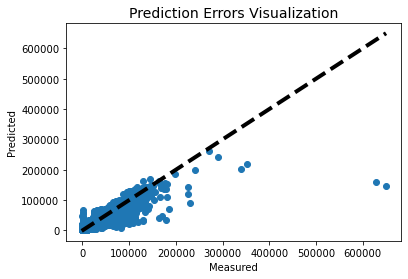

In [45]:
y_etr_test, y_etr_pred = plot_pred(y_test, y_pred)

## Reference
http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf
https://towardsdatascience.com/balancing-bias-and-variance-to-control-errors-in-machine-learning-16ced95724db
https://towardsdatascience.com/decision-trees-in-machine-learning-641b9c4e8052
https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/overview
https://www.youtube.com/playlist?list=PLLssT5z_DsK-h9vYZkQkYNWcItqhlRJLN


An Introduction to Statistical Learning by Gareth James, Daniela Witten, Trevor Hastie, Robert Tibshirani

#### Linear Regression
https://scikit-learn.org/stable/modules/linear_model.html?highlight=forward%20selection

#### Decision Tree
https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning

#### RandomForestRegressor
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html?highlight=extratreesregressor

#### ExtraTreesRegressor
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html?highlight=extratreesregressor